In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import codebase
from codebase import volume_pipeline

In [2]:
# Local load
fw_DS = xr.open_dataset('../LakePowell_CYGNSS_binary.nc')
fw_DA = fw_DS['Watermask'].rio.write_crs("ESRI:54017")

In [3]:
fw_DA

<xarray.DataArray 'Watermask' (time: 57, y: 19, x: 36)>
[38988 values with dtype=int8]
Coordinates:
  * x            (x) float64 -1.076e+07 -1.076e+07 ... -1.073e+07 -1.073e+07
  * y            (y) float64 4.417e+06 4.416e+06 4.415e+06 ... 4.401e+06 4.4e+06
  * time         (time) datetime64[ns] 2018-08-01 2018-09-01 ... 2023-04-01
    spatial_ref  int32 0
Attributes:
    units:         Binary mask of surface water
    comments:      Surface water = 1, ocean/land/no data = 0
    grid_mapping:  spatial_ref

In [4]:
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA,input_core_dims=['x','y'])

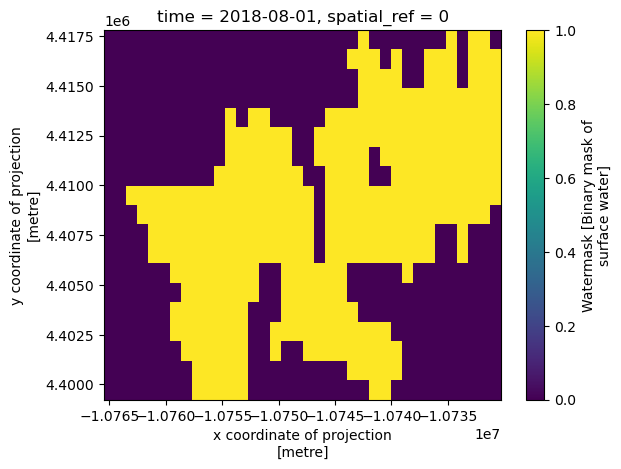

In [5]:
fw_DA.isel(time=0).plot()

C:\Users\asche\AppData\Local\Temp\ipykernel_1968\3347167260.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grealm_df['Date'] = pd.to_datetime(grealm_df['Date'], format="%Y%m%d")


<Axes: xlabel='Date'>

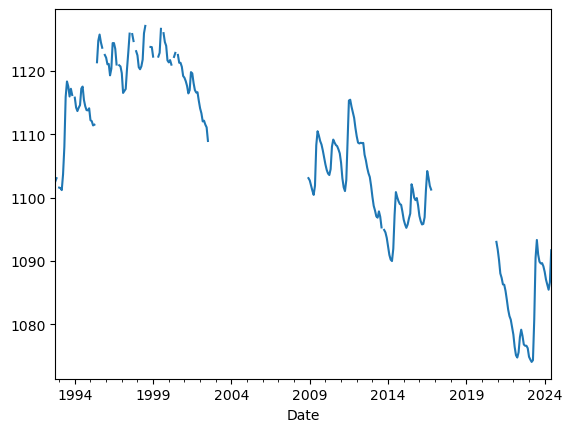

In [6]:
# Clunky dataprocessing. A version stuck in Savio does more streamlined processing.
# (The larger file, not "smooth" in the url, provides the same data)

grealm_url = "https://ipad.fas.usda.gov/lakes/images/lake000462.10d.2.smooth.txt"
grealm_raw = pd.read_table(grealm_url,header=12,sep = ' ',skipinitialspace=True)

grealm_raw.columns = ['Date', 'Hour', 'Minute', 'Height_from_JASON2','Height_from_EGM2008']
grealm_df = grealm_raw[grealm_raw['Height_from_EGM2008'] != 9999.99]
grealm_df['Date'] = pd.to_datetime(grealm_df['Date'], format="%Y%m%d")

grealm_series = grealm_df['Height_from_EGM2008']
grealm_series.index = grealm_df['Date']
grealm_M = grealm_series.resample("ME", label="left", closed="left").mean()
grealm_M.index = grealm_M.index + pd.Timedelta("1D")

grealm_M.plot()

In [7]:
area_m2 = codebase.area_calcs.CYGNSS_001_area_calculation(fw_DA)
area_m2_series = area_m2.to_frame().squeeze()

Projected to equal area


In [8]:
pd.to_datetime('01-June-2021')

Timestamp('2021-06-01 00:00:00')

In [9]:
grealm_cuttime , area_cuttime = codebase.time_series_calcs.intersecting_timeframes(grealm_M, area_m2_series,buffer=0)
grealm_matchtime = grealm_cuttime[grealm_cuttime.index >= pd.to_datetime('01-June-2021')]
area_matchtime = area_cuttime[area_cuttime.index >= pd.to_datetime('01-June-2021')]

<Axes: xlabel='Date'>

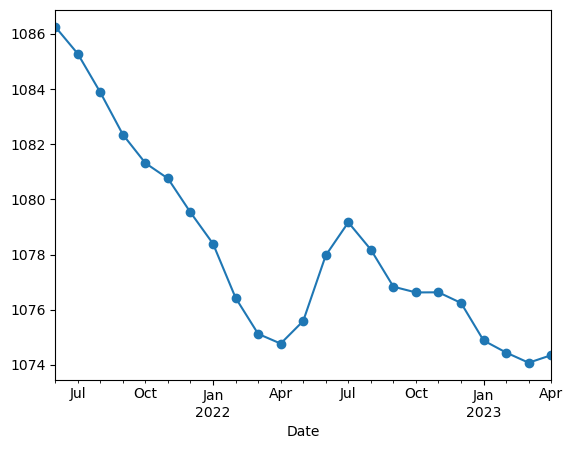

In [10]:
grealm_matchtime.plot(marker='o')
# area_matchtime.plot()

In [12]:
deltaV_m3 = volume_pipeline.calculate_trapezoidal_volume(area_vec = area_matchtime,elev_vec=grealm_matchtime)

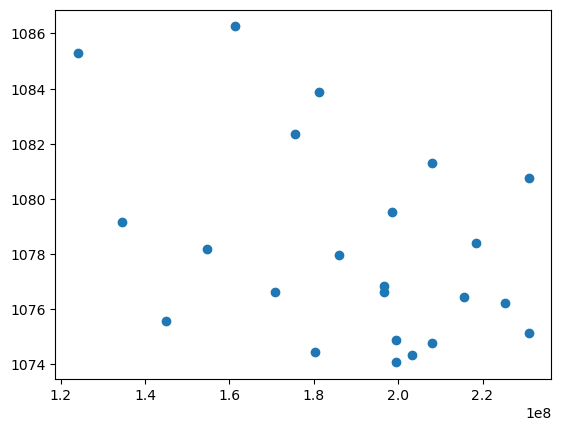

In [18]:
plt.scatter(area_matchtime,grealm_matchtime)

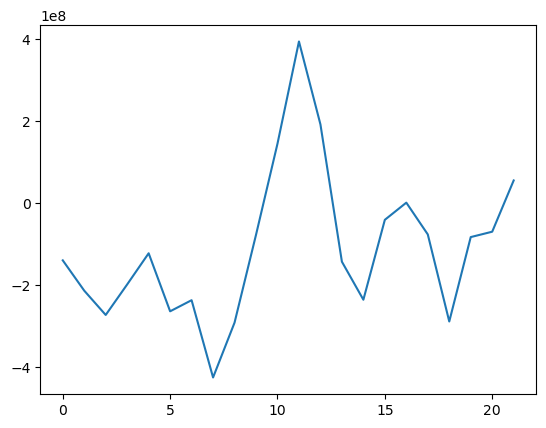

In [14]:
plt.plot(deltaV_m3)